In [99]:
using Images
using Statistics
using Plots

In [252]:
# Import iamge stack
img_path = "../CroppedMovies/test.tif"
img = load(img_path)
# Use stack sum to find polarity patch(es)
avgimg = mean(img, dims=(3))[:,:,1]
bin = avgimg .> maximum(avgimg)/2             # Half max of average is used as threshold
bin_lab = label_components(bin)             # Label connected components in binary mask
max_loc = findmax(bin.*avgimg)[2]              # Find single connected component from binary with highest value
max_lab = bin_lab[max_loc]                  
max_bin = bin_lab .== max_lab               # Make mask only around correct component
masked = avgimg .* max_bin                   # Make masked time averaged image (not used)
# Use masked image to plot sum intensity over time
im_all = Float64.(img)
im_masked = im_all .* max_bin

t = range(1,length(im_masked[1,1,:]))/(60/5) # Convert from 1 frame every 5 sec, to minutes
plot(t, sum(im_masked, dims=(1,2))[1,1,:], xticks=range(1,6)*5)
del = im_masked;

In [251]:
# Import iamge stack
img_path = "../CroppedMovies/NOTDEL-cell2.tif"
img = load(img_path)
# Use stack sum to find polarity patch(es)
avgimg = mean(img, dims=(3))[:,:,1]
bin = avgimg .> maximum(avgimg)/2             # Half max of average is used as threshold
bin_lab = label_components(bin)             # Label connected components in binary mask
max_loc = findmax(bin.*avgimg)[2]             # Find single connected component from binary with highest value
max_lab = bin_lab[max_loc]                  
max_bin = bin_lab .== max_lab               # Make mask only around correct component
masked = avgimg .* max_bin                   # Make masked time averaged image (not used)
# Use masked image to plot sum intensity over time
im_all = Float64.(img)
im_masked = im_all .* max_bin

t = range(1,length(im_masked[1,1,:]))/(60/5) # Convert from 1 frame every 5 sec, to minutes
plot(t, sum(im_masked, dims=(1,2))[1,1,:], xticks=range(1,6)*5)
wt = im_masked;

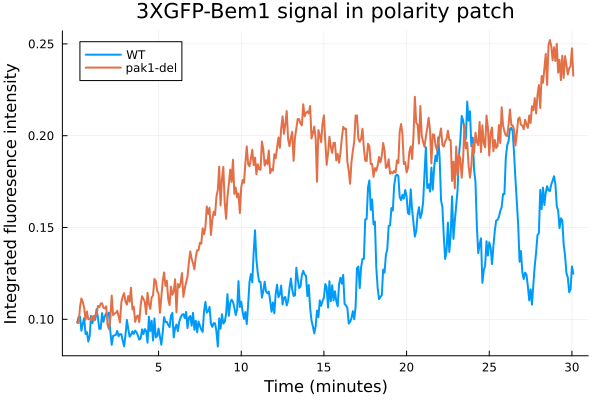

In [283]:
plot(t, sum(wt, dims=(1,2))[1,1,:], xticks=range(1,6)*5, linewidth=2, label="WT", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity")
plot!(t, sum(del, dims=(1,2))[1,1,:], linewidth=2, label="pak1-del", title="3XGFP-Bem1 signal in polarity patch")

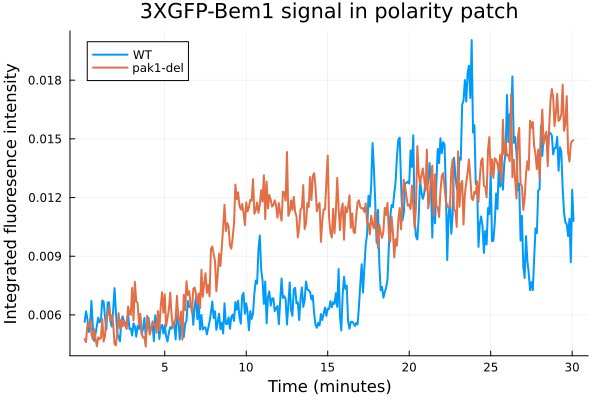

In [284]:
plot(t, maximum(wt, dims=(1,2))[1,1,:], xticks=range(1,6)*5, linewidth=2, label="WT", xlabel="Time (minutes)", ylabel="Integrated fluoresence intensity")
plot!(t, maximum(del, dims=(1,2))[1,1,:], linewidth=2, label="pak1-del", title="3XGFP-Bem1 signal in polarity patch")